# This file does a robustness check for the slope analysis (Fig 3) on the INDVOL paper.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
import json
from functools import reduce
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import linregress

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
sns.set('talk')

_____________________

# 0. Helper functions

In [2]:
# this function runs a t-test
def compare_ttest(sample1,sample2):
    t_values, p_values = stats.ttest_ind(sample1.T, sample2.T)
    return t_values, p_values

# this function runs two chi-squared tests to compare distributions 'u' and 'v' and averages them
def symmetrised_chi_square(u,v):
    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)           
    return np.mean([p_value1, p_value2])

# this function runs chi-squared tests comparing two dataframes
def compare_symmetric_chi2(df1, df2):
    chi2s = []
    
    for col in df1.columns:
        u = df1[col]
        v = df2[col]

        u[u==0] = 1
        v[v==0] = 1

        u_exp = u/u.sum() * sum(v)
        v_exp = v/v.sum() * sum(u)
        
        chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
        chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        
        
        out_p_value = np.mean([p_value1, p_value2])
        chi2s += [ out_p_value ]
    return chi2s

# this function runs chi squared values on a pair of columns and takes the largest (most conservative) value
def compare_symmetric_chi2_single_col(u, v):
    u_exp = u/u.sum() * sum(v)
    v_exp = v/v.sum() * sum(u)

    chisq1, p_value1 = stats.chisquare(f_obs=u, f_exp=v_exp)
    chisq2, p_value2 = stats.chisquare(f_obs=v, f_exp=u_exp)        

    out_p_value = max([p_value1, p_value2])
    chi2s       = out_p_value
    return chi2s

In [3]:
# To remove outliers:
# 1 - Estimate median
# 2 - Estimate median deviation from the median
# 3 - Exclude people who deviate more than (3 deviations from the median)*M, where M represents the pop size

def remove_outliers(series):
    absolute_deviation_from_median = np.abs(series - series.median())
    M = len(series) # number of measurements

    b   = 1.4826
    MAD = b * absolute_deviation_from_median.median()

    outliers = absolute_deviation_from_median > 3*MAD
    series_without_outliers = series[~outliers]

    return series_without_outliers

In [4]:
issues = ['Human rights', 'Climate change', 'Immigration', 'Hate speech', 'Social inequality',
          'Fake news', "Women's rights", 'LGBTQ  rights', 'EU membership', 'COVID-19']

_________________

# 1. Load data and transform it into the format we'll need for analysis

In [5]:
questions2tags = {
 'The government should be doing more to tackle climate change.':'Climate change',
 'More should be done to ensure women have equal rights to men.':"Women's rights",
 'It is important to ensure LGBTQ  people have the same rights as other members of society.':'LGBTQ  rights',
 'Social media websites should not display fake news stories.':'Fake news',
 'The government should reduce the level of immigration into Britain.':'Immigration',
 'The government should do more to protect human rights regardless of race, religion etc.':'Human rights',
 'I would support action to tackle online hate speech.':'Hate speech',
 'The government should take more steps to reduce social inequality.':'Social inequality',
 'Leaving the EU will be positive for the United Kingdom.':'EU membership',
 'During the COVID-19 crisis, the government should prioritise saving lives over protecting the economy.':'COVID-19'
}

In [6]:
# Load data
df_to_be_analysed = pd.read_csv('INDVOL_data_two_waves.tsv', sep='\t')

df_to_be_analysed.head()

,userid,issue,wave,score,ranking,reaction_time_ms,finaltime,socinfo
0,5cb4b1cc96d87400010836bd,Human rights,wave1,0.977205,1,4199,"03 Sep 2020, 12:25:10",0.0
1,5cb4b1cc96d87400010836bd,Climate change,wave1,0.977205,4,2481,"03 Sep 2020, 12:25:10",0.0
2,5cb4b1cc96d87400010836bd,Immigration,wave1,0.977205,2,2797,"03 Sep 2020, 12:25:10",0.0
3,5cb4b1cc96d87400010836bd,Hate speech,wave1,0.655063,6,3380,"03 Sep 2020, 12:25:10",0.0
4,5cb4b1cc96d87400010836bd,Social inequality,wave1,0.658228,9,4580,"03 Sep 2020, 12:25:10",0.0


## 1.1 Define some helper variables

In [7]:
df = df_to_be_analysed

In [8]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

d_H10 = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

In [9]:
user_opinions = {}

for _, row in d_H10.iterrows():
    userid  = row['userid']
    wave    = row['wave']
    score   = row['score']
    issue   = row['issue']
    ranking = row['ranking']
    socinfo = row['socinfo']
    
    if userid not in user_opinions:
        user_opinions[userid] = {}

    if issue not in user_opinions[userid]:
        user_opinions[userid][issue] = { 'score':{}, 'ranking':{} }
    
    user_opinions[userid][issue]['socinfo']       = socinfo
    user_opinions[userid][issue]['score'][wave]   = score
    user_opinions[userid][issue]['ranking'][wave] = ranking

In [10]:
tuples = []

for userid in user_opinions:
    for issue in user_opinions[userid]:
        if (len(user_opinions[userid][issue]['score']) == 2):

            w1_score   = user_opinions[userid][issue]['score']['wave1']
            w1_ranking = user_opinions[userid][issue]['ranking']['wave1']
            soc_info   = user_opinions[userid][issue]['socinfo']
            try:
                delta_score = user_opinions[userid][issue]['score']['wave2_control']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_control'] - w1_ranking                
                group = 'control'
            except:
                delta_score = user_opinions[userid][issue]['score']['wave2_treatment']     - w1_score
                delta_ranking = user_opinions[userid][issue]['ranking']['wave2_treatment'] - w1_ranking
                group = 'treatment'
                
            tuples += [ (userid, group, issue, delta_score, delta_ranking, soc_info, w1_score, w1_ranking) ]
            
df_deltas = pd.DataFrame(tuples, columns=['userid','group','issue','delta_score','delta_ranking','soc_info', 'w1_score', 'w1_ranking'])

In [11]:
df_deltas_treatment = df_deltas[df_deltas.group=='treatment']
df_deltas_control   = df_deltas[df_deltas.group=='control']

In [12]:
personality_scores = {}

userids = df[df.wave=='wave1'].userid.unique()

for userid in userids:
    d = df[ (df.userid==userid) & (df.wave=='wave1') ]
    
    try:

        q1 = d[d.issue=='I see myself as sympathetic, warm.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as critical, quarrelsome.'].iloc[0]['score']
        agreeableness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as open to new experiences, complex.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as conventional, uncreative.'].iloc[0]['score']
        openness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as dependable, self-disciplined.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as disorganized, careless.'].iloc[0]['score']
        conscientiousness = np.mean([q1,1-q2])

        q1 = d[d.issue=='I see myself as extraverted, enthusiastic.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as reserved, quiet.'].iloc[0]['score']
        extraversion = np.mean([q1,1-q2])
        
        q1 = d[d.issue=='I see myself as anxious, easily upset.'].iloc[0]['score']
        q2 = d[d.issue=='I see myself as calm, emotionally stable.'].iloc[0]['score']
        neuroticism = np.mean([q1,1-q2])
    
        personality_scores[userid] = [agreeableness, openness, conscientiousness, extraversion, neuroticism]

    except IndexError:
        continue

In [13]:
users_wave2 = df[df.wave.isin(['wave2_control','wave2_treatment'])].userid.unique()

df_op_change = df[ df.userid.isin(users_wave2) & (df.issue.isin(issues)) ]

_________________________
# 2. Main figures

##  Fig 1: Opinion distributions

In [14]:
bins_opinion = np.linspace(-.75,.75,16)

print(bins_opinion)

[-0.75 -0.65 -0.55 -0.45 -0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35
  0.45  0.55  0.65  0.75]


In [15]:
bins_ranking = np.arange(-8.5,8.5,1)

print(bins_ranking)

[-8.5 -7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5
  5.5  6.5  7.5]


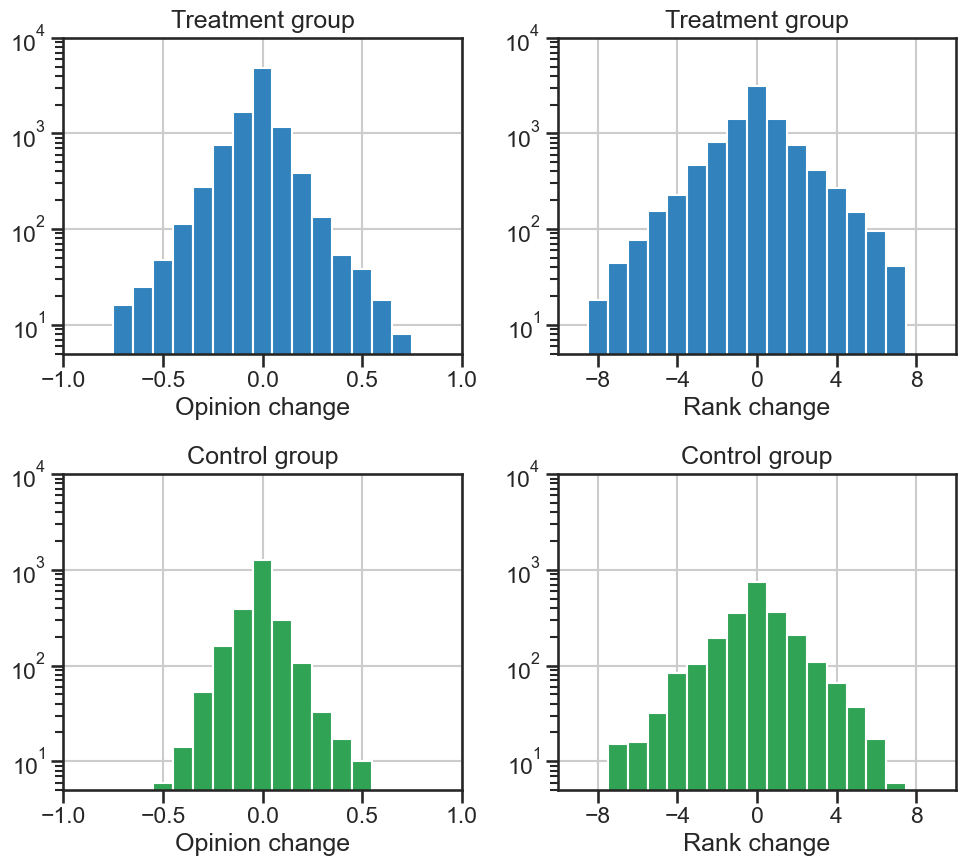

In [16]:
sns.set('talk')
sns.set_style('ticks')
import matplotlib.colors

pad  = 7
colors = [plt.cm.tab20c(0),plt.cm.tab20c(2),plt.cm.tab20c(8),plt.cm.tab20c(10)]
colors = [plt.cm.tab20c(0),plt.cm.tab20c(0),plt.cm.tab20c(8),plt.cm.tab20c(8)]

delta_column = 'delta_score'

fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.T.flatten()

ax = axs[0]
df_deltas_treatment[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[0])
ax.set_title(r'Treatment group', pad=pad)

ax = axs[1]
df_deltas_control[delta_column].hist(bins=bins_opinion, ax=ax, color=colors[2])
ax.set_title('Control group', pad=pad)

for ax in axs[:2]:
    ax.set_xlim(-.8,.8)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Opinion change')
    ax.set_xticks(np.arange(-1,1.5,.5))
    ax.set_yscale('log')


delta_column = 'delta_ranking'

ax = axs[2]
df_deltas_treatment[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[1])
ax.set_title('Treatment group', pad=pad)

ax = axs[3]
df_deltas_control[delta_column].hist(bins=bins_ranking, ax=ax, color=colors[3])
ax.set_title('Control group', pad=pad)

for ax in axs[2:]:
    ax.set_xlim(-10,10)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Rank change')
    ax.set_xticks(np.arange(-8,10,4))
    ax.set_yscale('log')   
    
plt.tight_layout()
plt.savefig('images/Fig-distributions-with-outliers.png')
plt.show()

# If we want to add text to the figures, here's some sample code
# ax.text(-8, 600, "D.", fontsize=20, weight="bold", bbox=dict(facecolor='w', alpha=1.0))

## SI: make the same figure, but removing outliers

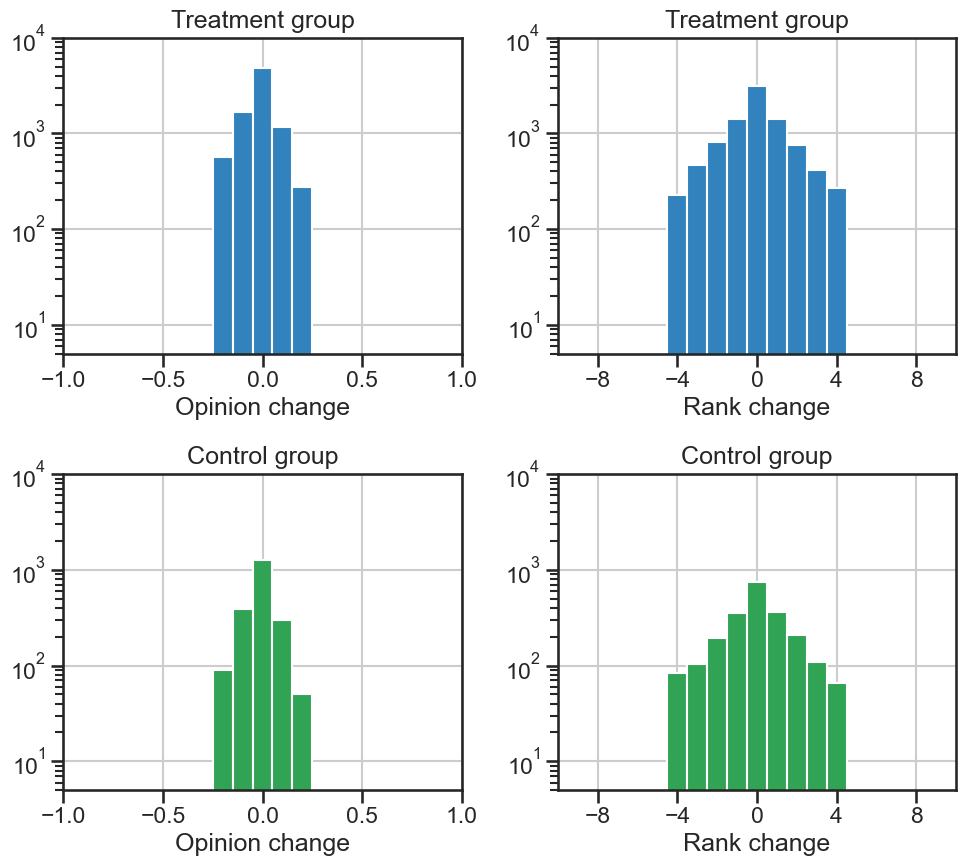

In [17]:
sns.set('talk')
sns.set_style('ticks')
import matplotlib.colors

pad  = 7
colors = [plt.cm.tab20c(0),plt.cm.tab20c(2),plt.cm.tab20c(8),plt.cm.tab20c(10)]
colors = [plt.cm.tab20c(0),plt.cm.tab20c(0),plt.cm.tab20c(8),plt.cm.tab20c(8)]

delta_column = 'delta_score'

fig, axs = plt.subplots(2,2,figsize=(10,9))
axs = axs.T.flatten()

ax = axs[0]
remove_outliers(df_deltas_treatment[delta_column]).hist(bins=bins_opinion, ax=ax, color=colors[0])
ax.set_title(r'Treatment group', pad=pad)

ax = axs[1]
remove_outliers(df_deltas_control[delta_column]).hist(bins=bins_opinion, ax=ax, color=colors[2])
ax.set_title('Control group', pad=pad)

for ax in axs[:2]:
    ax.set_xlim(-.8,.8)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Opinion change')
    ax.set_xticks(np.arange(-1,1.5,.5))
    ax.set_yscale('log')


delta_column = 'delta_ranking'

ax = axs[2]
remove_outliers(df_deltas_treatment[delta_column]).hist(bins=bins_ranking, ax=ax, color=colors[1])
ax.set_title('Treatment group', pad=pad)

ax = axs[3]
remove_outliers(df_deltas_control[delta_column]).hist(bins=bins_ranking, ax=ax, color=colors[3])
ax.set_title('Control group', pad=pad)

for ax in axs[2:]:
    ax.set_xlim(-10,10)
    ax.set_ylim(5,10000)
    ax.set_xlabel('Rank change')
    ax.set_xticks(np.arange(-8,10,4))
    ax.set_yscale('log')   
    
plt.tight_layout()
plt.savefig('images/Fig-distributions-without-outliers.png')
plt.show()

________________________________________________

# Fig 3 - Contrarians

First, prepare the data for the figure:

In [18]:
df = df_deltas_treatment

In [19]:
slopes = []
userids = sorted(df.userid.unique())
for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info
    slope, intercept = np.polyfit(x,y,1)
    slopes += [slope]
slopes = np.array(slopes)

### Define **contrarians** as subjects for which the slope in panels A and B is less than 0:

In [20]:
contrarians = set([ userid for userid,slope in zip(userids,slopes) if slope<0 ])
conformists = set([ userid for userid,slope in zip(userids,slopes) if slope>=0 ])

In [21]:
print(f'{len(contrarians)} contrarians, or', round(len(contrarians)/len(userids),4))
print(f'{len(conformists)} conformists, or', round(len(conformists)/len(userids),4))
print(len(userids),'total')

404 contrarians, or 0.4222
553 conformists, or 0.5778
957 total


In [22]:
df = df_deltas_treatment

### Prepare data on attitude vectors for PCA:

In [23]:
userids = sorted(df.userid.unique())

datapoints = []
for userid in userids:
    datapoint = df[df.userid==userid].sort_values('issue')['w1_score'].values
    datapoints += [ datapoint ] 
    
datapoints = np.array(datapoints)

print(datapoints.shape)

(957, 10)


### Run PCA:

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = datapoints
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

In [25]:
userids = sorted(df_deltas_treatment.userid.unique())

datapoints = []
for userid in userids:
    datapoint = df[df.userid==userid].sort_values('issue')['w1_score'].values
    datapoints += [ datapoint ] 
    
X = np.array(datapoints)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit(X_scaled).transform(X_scaled)

### Pick two users for the examples on subplots A and B:

In [26]:
userid_pos_corr = '5f18362e7f876d064235cd4d'
userid_neg_corr = '5eb87f52d249ac7d7d99aabd'

In [27]:
userid = userid_pos_corr
d = df[df.userid==userid]
z = d.w1_score + d.delta_score

idx = 6572
print(d.loc[idx][['w1_score','soc_info','delta_score']])
print(z[idx])

# Result
# op1      = 0.12
# soc_info = 0.68
# op2      = 0.64

w1_score       0.124658
soc_info           0.68
delta_score    0.518432
Name: 6572, dtype: object
0.6430897485997134


In [28]:
userid = userid_neg_corr
d = df[df.userid==userid]
z = d.w1_score + d.delta_score

idx = 11408
print(d.loc[idx][['w1_score','soc_info','delta_score']])
print(z[idx])

# Result
# op1      = 0.10
# soc_info = 0.40
# op2      = -0.01

w1_score       0.103334
soc_info            0.4
delta_score   -0.010218
Name: 11408, dtype: object
0.093115340401073


In [29]:
circleA = {'op1':0.12, 'soc_info':0.68 ,'op2':0.64}
circleB = {'op1':0.10, 'soc_info':0.40 ,'op2':0.093}

for c in [circleA,circleB]:
    c['x'] = c['soc_info']-c['op1']
    c['y'] = c['op2']-c['op1']

### Now let's make the figure

___________________________

# Robustness check

One could also go to a more fine-grained level and separate (1) high-variance participants, i.e. those with more random-looking behaviour, who produce some highly contrarian responses as well as some highly conformist responses, and as a result yield a poor prediction from the linear regression, from (2) Low-variance participants, i.e. those whose behaviour is less erratic, and whose response is very well predicted by their linear regression.

The point about the N=10 data points and uncertainty is more interesting, and I’ll do some work on it as a robustness test for the appendix. Then I can draft this answer to the reviewer.

In [31]:
def get_colours(x):
    palette = sns.color_palette('tab10')
    colours = []
    for i in x:
        rounded = i - i%10
        for colour, number in zip(palette, np.arange(0,100,10)):
            if rounded == number:               
                break
        colours.append(colour)
    return colours

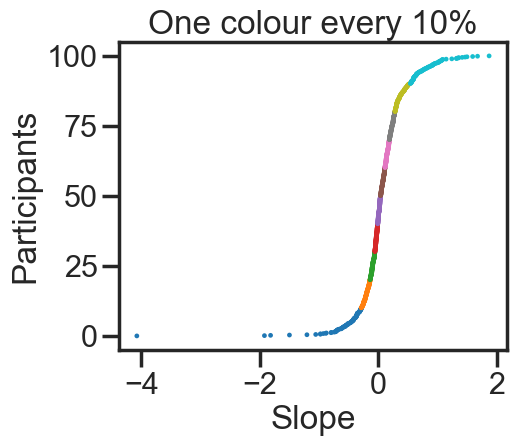

In [32]:
sorted_slopes = sorted(slopes)
percentages   = np.arange(len(slopes))/len(slopes) * 100

c = get_colours(percentages)

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(sorted_slopes,percentages,c=c,s=2)
ax.set_xlabel('Slope')
ax.set_ylabel('Participants')
ax.set_title('One colour every 10%')

plt.show()

In [33]:
rounded = 10
for slope, percentage in zip(sorted_slopes,percentages):
    if percentage > rounded:
        print(f'The lowest {rounded}% are hit when the slope is {slope:+.3f}')
        rounded += 10

The lowest 10% are hit when the slope is -0.288
The lowest 20% are hit when the slope is -0.139
The lowest 30% are hit when the slope is -0.058
The lowest 40% are hit when the slope is -0.009
The lowest 50% are hit when the slope is +0.037
The lowest 60% are hit when the slope is +0.113
The lowest 70% are hit when the slope is +0.188
The lowest 80% are hit when the slope is +0.283
The lowest 90% are hit when the slope is +0.541


In [34]:
rounded = 25

for slope, percentage in zip(sorted_slopes,percentages):
    if percentage > rounded:
        print(f'The lowest {rounded}% are hit when the slope is {slope:+.3f}')
        rounded += 50

The lowest 25% are hit when the slope is -0.096
The lowest 75% are hit when the slope is +0.232


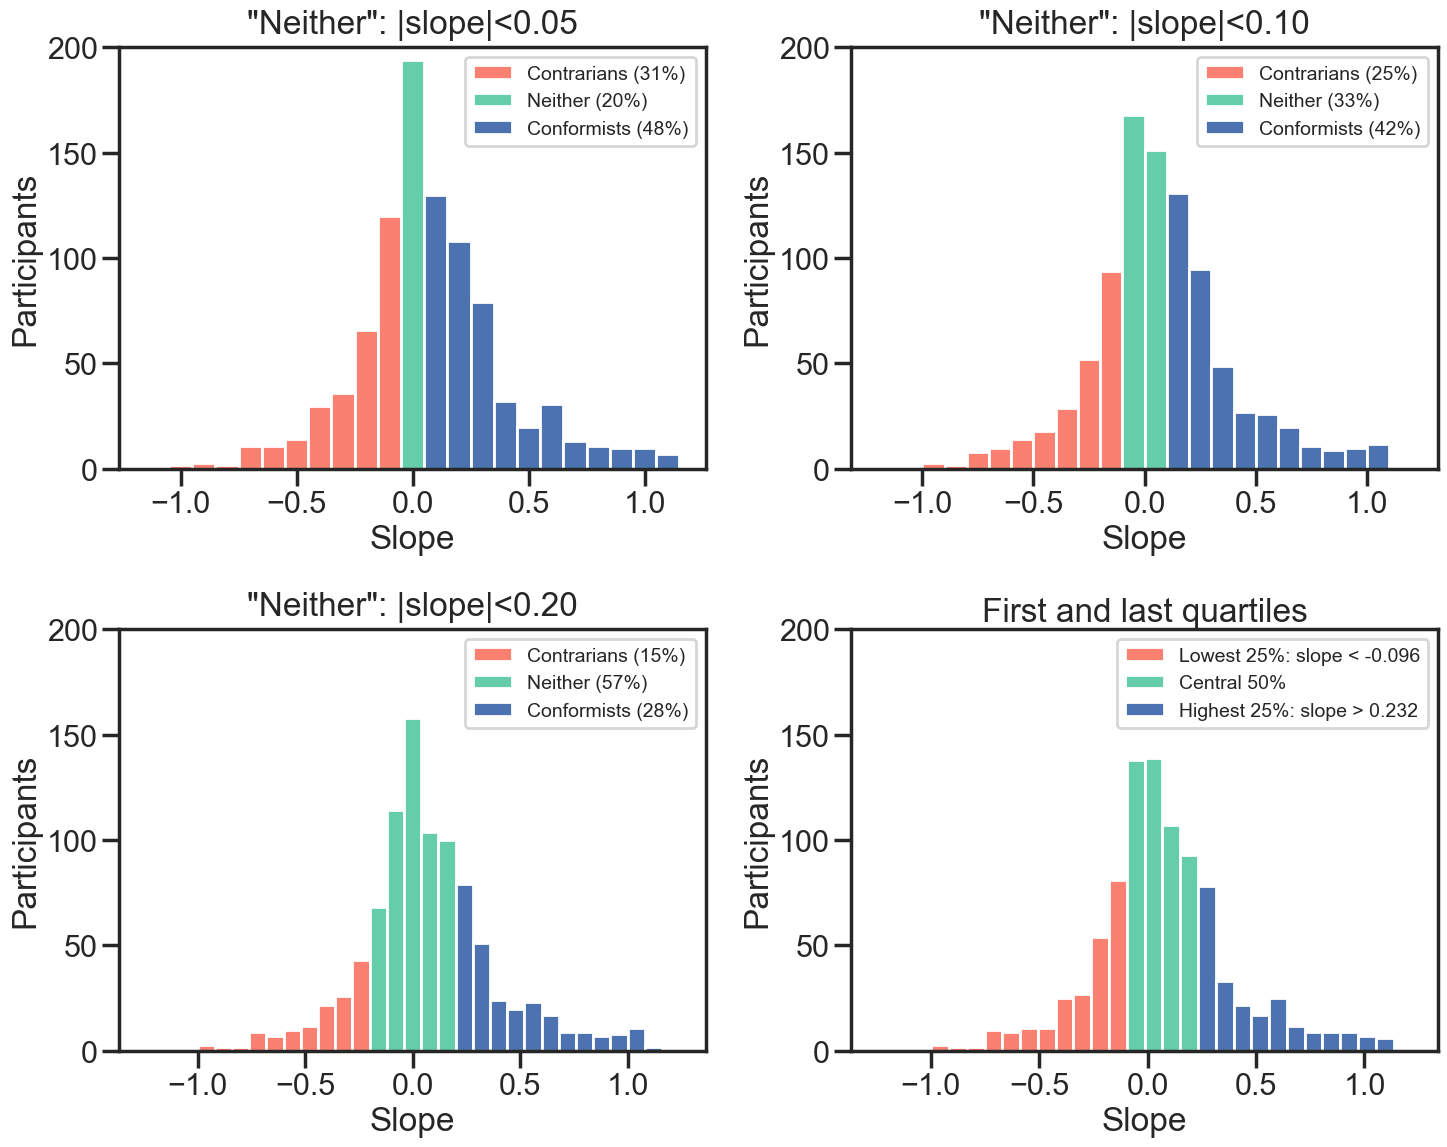

In [35]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.flatten()

slope_thresholds = [0.05, 0.1, 0.2]
nbins_centre     = [2, 3, 6]

for ax, slope_threshold, nbins in zip(axs, slope_thresholds, nbins_centre):
    threshold_1 = -slope_threshold
    threshold_2 = slope_threshold

    mask1 = (slopes<threshold_1)
    mask2 = (slopes>threshold_2)
    mask3 = ~(mask1) & ~(mask2)

    bins3 = np.linspace(threshold_1, threshold_2, nbins)
    binwidth = np.diff(bins3)[0]
    bins1 = np.arange(threshold_1, -1.25, -1*binwidth)[::-1]
    bins2 = np.arange(threshold_2, 1.25,  binwidth)


    percentage_left   = "{0:.0%}".format(sum(mask1)/len(slopes))
    percentage_right  = "{0:.0%}".format(sum(mask2)/len(slopes))
    percentage_centre = "{0:.0%}".format(sum(mask3)/len(slopes))

# include constant in ols models, w
    label_contrarians = f'Contrarians ({percentage_left})'
    label_conformists = f'Conformists ({percentage_right})'
    label_centre      = f'Neither ({percentage_centre})'

    ax.hist(slopes[mask1],  bins=bins1, color='salmon', label=label_contrarians)
    ax.hist(slopes[mask3],  bins=bins3, color='mediumaquamarine', label=label_centre)
    ax.hist(slopes[mask2],  bins=bins2, label=label_conformists)

    ax.set_xlabel('Slope')
    ax.set_ylabel('Participants')
    ax.set_ylim(0,200)
    ax.set_title(f'"Neither": |slope|<{slope_threshold:.2f}', pad=10)
    #ax.set_title(f'"Neither": -{slope_threshold:.2f} < slope < +{slope_threshold:.2f}', pad=10)
    ax.legend(loc=1, fontsize=14)



#--------------------------------------#
#
#            Make last plot
#
#--------------------------------------#

ax = axs[3]

threshold_1 = -0.096
threshold_2 = 0.232

mask1 = (slopes<threshold_1)
mask2 = (slopes>threshold_2)
mask3 = ~(mask1) & ~(mask2)

bins3 = np.linspace(threshold_1, threshold_2, 5)
binwidth = np.diff(bins3)[0]
bins1 = np.arange(threshold_1, -1.25, -1*binwidth)[::-1]
bins2 = np.arange(threshold_2, 1.25,  binwidth)


percentage_left   = "{0:.0%}".format(sum(mask1)/len(slopes))
percentage_right  = "{0:.0%}".format(sum(mask2)/len(slopes))
percentage_centre = "{0:.0%}".format(sum(mask3)/len(slopes))

label_contrarians = f'Lowest 25%: slope < -0.096'
label_conformists = f'Highest 25%: slope > 0.232'
label_centre      = f'Central 50%'

ax.hist(slopes[mask1],  bins=bins1, color='salmon', label=label_contrarians)
ax.hist(slopes[mask3],  bins=bins3, color='mediumaquamarine', label=label_centre)
ax.hist(slopes[mask2],  bins=bins2, label=label_conformists)

ax.set_xlabel('Slope')
ax.set_ylabel('Participants')
ax.set_ylim(0,200)
ax.legend(loc=1, fontsize=14)
ax.set_title('First and last quartiles')

plt.tight_layout()

plt.savefig('images/SI-Robustness-checks-1.png')
plt.show()

_____________

# Regression

In [36]:
df = df_deltas_treatment

In [37]:
userid = '5f18362e7f876d064235cd4d'
d = df[df.userid==userid]

y = d.delta_score
x = d.soc_info


In [38]:
import statsmodels.api as sm
import numpy as np

# include constant in ols models, which is not done by default
X = sm.add_constant(x)

model = sm.OLS(y,X)
results = model.fit()

In [39]:
results.summary()

c:\Users\fc410\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            delta_score   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     4.495
Date:                Tue, 04 Feb 2025   Prob (F-statistic):             0.0668
Time:                        12:05:01   Log-Likelihood:                 1.5507
No. Observations:                  10   AIC:                            0.8986
Df Residuals:                       8   BIC:                             1.504
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4690      0.217     -2.161      0.063      -0.969       0.031
soc_info       0.9098      0.429      2.120      0.067      -0.080       1.899
==============================================================================
Omnibus:                        0.239   Durbin-Watson:                   2.582
Prob(Omnibus):                  0.887   Jarque-Bera (JB):                0.059
Skew:                          -0.076   Prob(JB):                        0.971
Kurtosis:                       2.657   Cond. No.                         7.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
userids = sorted(df.userid.unique())
pvalues = []

for userid in userids:
    d = df[df.userid==userid]
    y = d.delta_score
    x = d.soc_info

    # include constant in ols models, which is not done by default
    X = sm.add_constant(x)
    model = sm.OLS(y,X)
    results = model.fit()
    pvalue = results.pvalues[1]
    pvalues.append(pvalue)

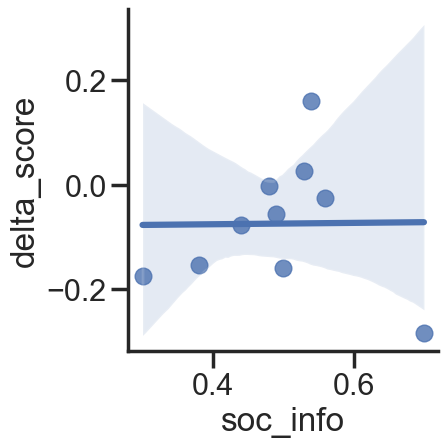

In [41]:
userid = userids[3]
d = df[df.userid==userid]
y = d.delta_score
x = d.soc_info

# include constant in ols models, which is not done by default
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
pvalue = results.pvalues[1]

sns.lmplot(x='soc_info', y='delta_score', data=d, fit_reg=True, ci=95, n_boot=1000)

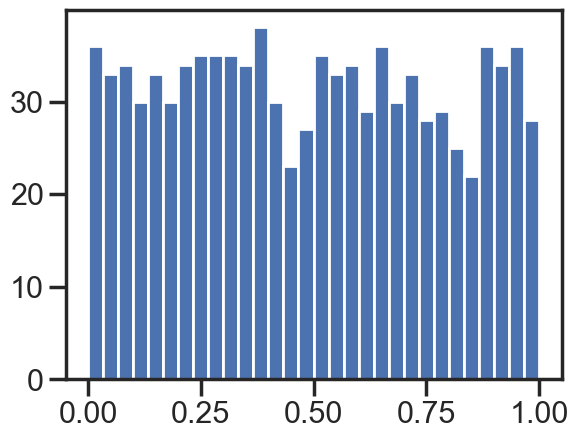

In [42]:
plt.hist(pvalues, bins=30)
plt.show()

In [43]:
significant_slopes = np.array([ s for s,p in zip(slopes, pvalues) if p<0.05])

In [44]:
sorted_significant_slopes = sorted(significant_slopes)
percentages   = np.arange(len(significant_slopes))/len(significant_slopes) * 100

rounded = 25

for slope, percentage in zip(sorted_significant_slopes,percentages):
    if percentage > rounded:
        print(f'The lowest {rounded}% are hit when the slope is {slope:+.3f}')
        rounded += 50

The lowest 25% are hit when the slope is +0.162
The lowest 75% are hit when the slope is +0.921


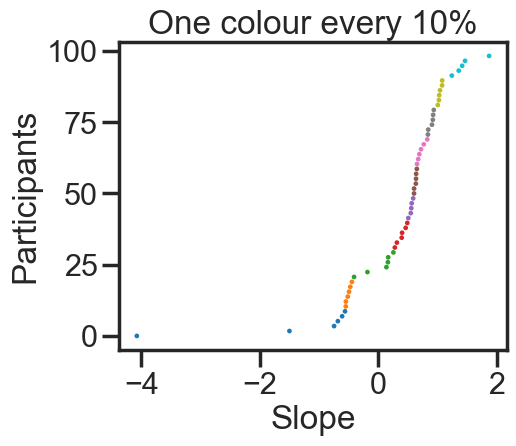

In [45]:
c = get_colours(percentages)

fig, ax = plt.subplots(figsize=(5,4))

ax.scatter(sorted_significant_slopes,percentages,c=c,s=2)
ax.set_xlabel('Slope')
ax.set_ylabel('Participants')
ax.set_title('One colour every 10%')

plt.show()

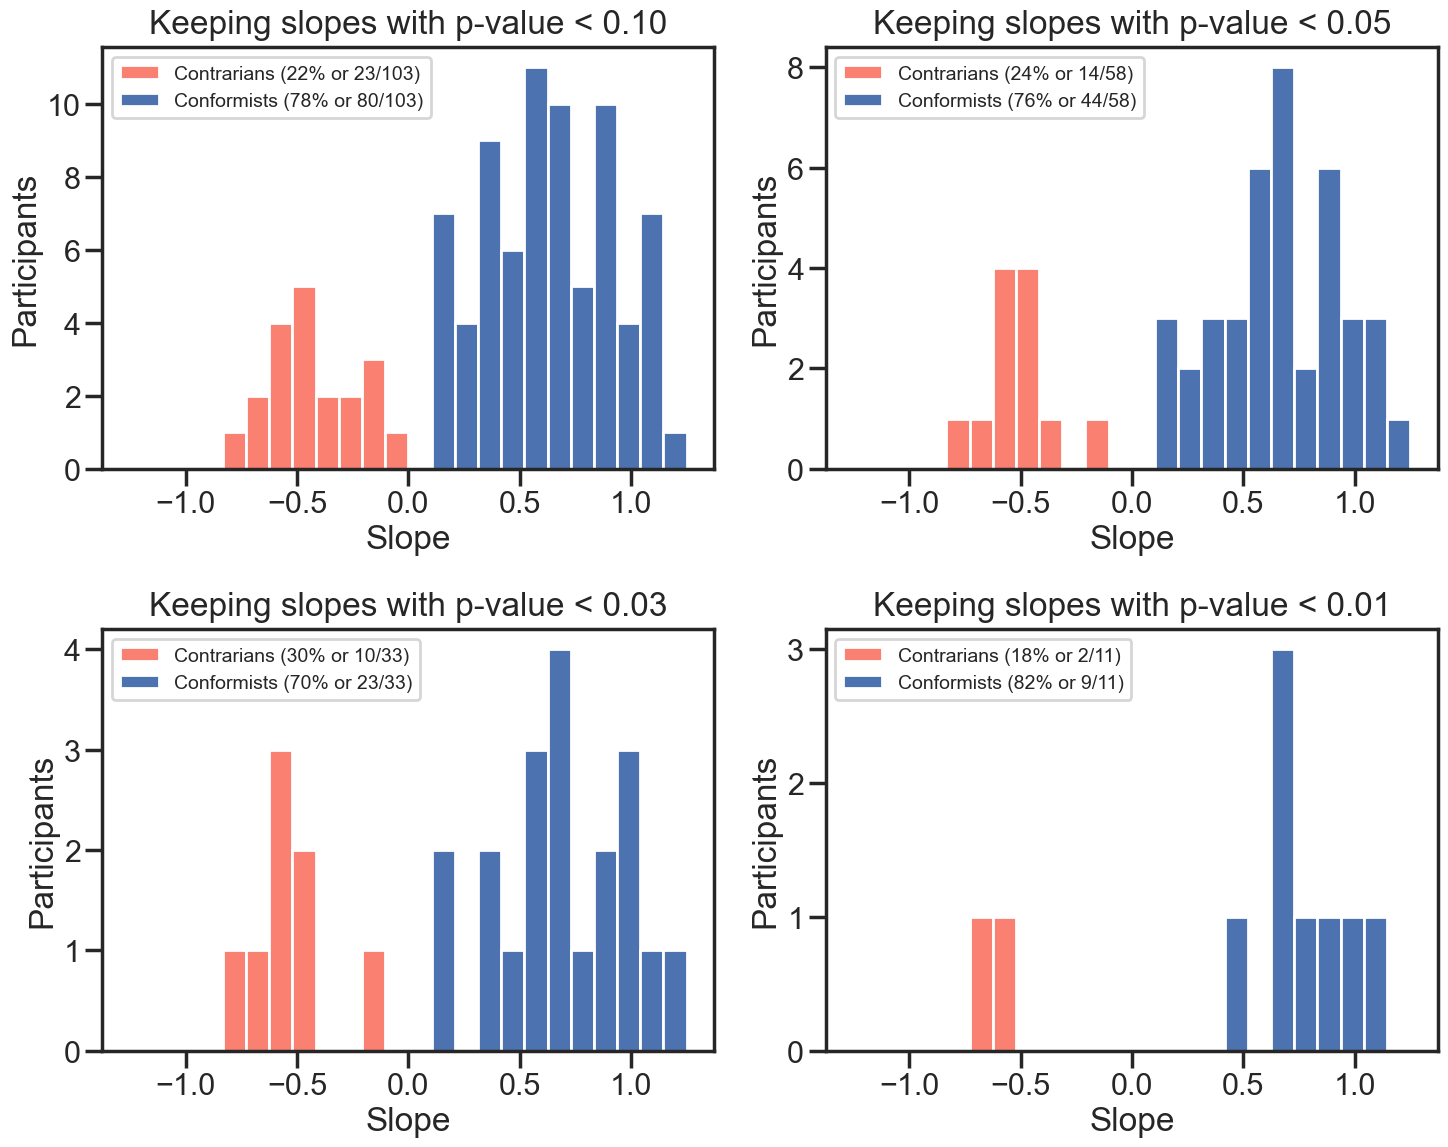

In [46]:
fig, axs = plt.subplots(2,2, figsize=(15,12))
axs = axs.flatten()

threshold_pvalues = [0.10, 0.05, 0.03, 0.01]
#threshold_pvalues = [1.00, 0.50, 0.30, 0.10]

for ax, p_value in zip(axs, threshold_pvalues):

    significant_slopes = np.array([ s for s,p in zip(slopes, pvalues) if p<p_value])

    mask1 = (significant_slopes<0)
    mask2 = (significant_slopes>=0)
    bins2 = np.linspace(-1.5, 1.5, 20)

    percentage_left   = "{0:.0%}".format(sum(mask1)/len(significant_slopes))
    percentage_right  = "{0:.0%}".format(sum(mask2)/len(significant_slopes))

    label_contrarians = f'Contrarians ({percentage_left} or {sum(mask1)}/{len(mask1)})'
    label_conformists = f'Conformists ({percentage_right} or {sum(mask2)}/{len(mask2)})'

    ax.hist(significant_slopes[mask1],  bins=bins, color='salmon', label=label_contrarians)
    ax.hist(significant_slopes[mask2],  bins=bins, label=label_conformists)

    ax.set_xlabel('Slope')
    ax.set_ylabel('Participants')
    #ax.set_ylim(0,12)
    ax.set_title(f'Keeping slopes with p-value < {p_value:.2f}', pad=10)

    ax.legend(loc=2, fontsize=14)


plt.tight_layout()

plt.savefig('images/SI-Robustness-checks-2.png')
plt.show()

The proportion in contrarians/conformists changes as we become more stringent regarding the p-value.

In [50]:
threshold_pvalues = np.arange(0.01,1.01,0.01)
tuples = []

threshold_slope = 0.05

for p_value in threshold_pvalues:

    significant_slopes = np.array([ s for s,p in zip(slopes, pvalues) if p<p_value])
    mask1 = (significant_slopes<-threshold_slope)
    mask2 = (significant_slopes>threshold_slope)
    percentage_left   = "{0:.0%}".format(sum(mask1)/len(significant_slopes))
    percentage_right  = "{0:.0%}".format(sum(mask2)/len(significant_slopes))
    percentage_centre = "{0:.0%}".format((len(significant_slopes)-sum(mask1)-sum(mask2))/len(significant_slopes))
    t = (p_value,sum(mask1),sum(mask2),len(mask1),
         sum(mask1)/len(significant_slopes),sum(mask2)/len(significant_slopes), (len(significant_slopes)-sum(mask1)-sum(mask2))/len(significant_slopes))
    tuples.append(t)

columns = ['threshold_pvalue','count_left','count_right','count','proportion_left','proportion_right','proportion_centre']
df_percentages = pd.DataFrame(tuples,columns=columns)

In [51]:
df_percentages

,threshold_pvalue,count_left,count_right,count,proportion_left,proportion_right,proportion_centre
0,0.01,2,9,11,0.181818,0.818182,0.000000
1,0.02,6,18,24,0.250000,0.750000,0.000000
2,0.03,10,23,33,0.303030,0.696970,0.000000
3,0.04,11,34,45,0.244444,0.755556,0.000000
4,0.05,14,44,58,0.241379,0.758621,0.000000
...,...,...,...,...,...,...,...
95,0.96,301,462,919,0.327530,0.502720,0.169750
96,0.97,301,462,931,0.323308,0.496241,0.180451
97,0.98,301,462,939,0.320554,0.492013,0.187433
98,0.99,301,462,946,0.318182,0.488372,0.193446


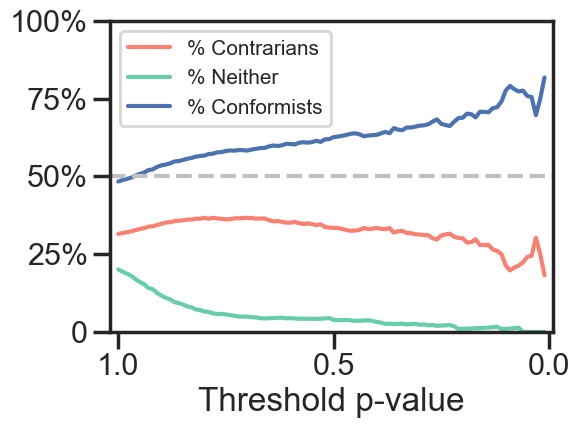

In [56]:
fig, ax = plt.subplots()
df_percentages.plot(x='threshold_pvalue',y='proportion_left', ax=ax, c='salmon')
df_percentages.plot(x='threshold_pvalue',y='proportion_centre',ax=ax, c='mediumaquamarine')
df_percentages.plot(x='threshold_pvalue',y='proportion_right',ax=ax, c='b')
ax.axhline(0.5, linestyle='--', c='silver')

plt.gca().invert_xaxis()
legend = ['% Contrarians','% Neither','% Conformists']
ax.legend(legend,loc=2, fontsize=15)

ax.set_xlabel('Threshold p-value')
ax.set_ylim(0,1)
ax.set_yticks([0,0.25,0.50,0.75,1])
ax.set_yticklabels(['0','25%','50%','75%','100%'])

ax.set_xlim(1.02,-0.01)

plt.tight_layout()
plt.savefig('images/SI-Robustness-checks-3.png')
plt.show()